### LSTM

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('C:/Users/91738/Desktop/CogNight/input/sleepdata_2.csv')
df['Sleep Quality'] = df['Sleep Quality'].str.rstrip('%').astype('float') / 100.0
df = df[df['Sleep Quality']>0.4]
data = df['Sleep Quality'].copy().reset_index().drop('index',axis=1)
df[['Date','Time']] = df['Start'].str.split(expand=True)
data = df[['Date','Sleep Quality']].copy().reset_index().drop('index',axis=1)
data

,Date,Sleep Quality
0,12-05-2019,0.60
1,13-05-2019,0.73
2,14-05-2019,0.86
3,15-05-2019,0.77
4,16-05-2019,0.78
...,...,...
902,21-03-2022,0.82
903,23-03-2022,0.72
904,24-03-2022,0.71
905,28-03-2022,0.77


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [5]:
data.mean()

Sleep Quality    0.787144
dtype: float64

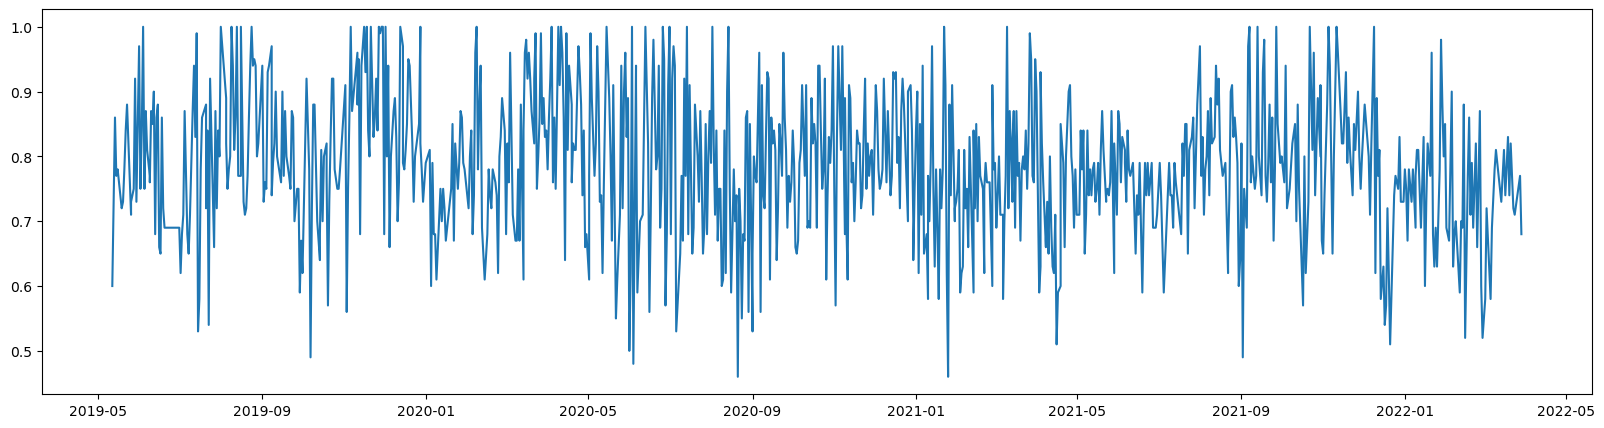

In [6]:
plt.figure(figsize=(20,5))
data['Date'] = pd.to_datetime(data['Date'],dayfirst=True)
plt.plot(data['Date'],data['Sleep Quality'])

In [7]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Sleep Quality(t-{i})'] = df['Sleep Quality'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Sleep Quality,Sleep Quality(t-1),Sleep Quality(t-2),Sleep Quality(t-3),Sleep Quality(t-4),Sleep Quality(t-5),Sleep Quality(t-6),Sleep Quality(t-7)
Date,,,,,,,,
2019-05-21,0.78,0.73,0.72,0.78,0.77,0.86,0.73,0.60
2019-05-22,0.84,0.78,0.73,0.72,0.78,0.77,0.86,0.73
2019-05-23,0.88,0.84,0.78,0.73,0.72,0.78,0.77,0.86
2019-05-26,0.71,0.88,0.84,0.78,0.73,0.72,0.78,0.77
2019-05-26,0.73,0.71,0.88,0.84,0.78,0.73,0.72,0.78
...,...,...,...,...,...,...,...,...
2022-03-21,0.82,0.74,0.83,0.74,0.81,0.73,0.81,0.78
2022-03-23,0.72,0.82,0.74,0.83,0.74,0.81,0.73,0.81
2022-03-24,0.71,0.72,0.82,0.74,0.83,0.74,0.81,0.73


In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[0.78, 0.73, 0.72, ..., 0.86, 0.73, 0.6 ],
       [0.84, 0.78, 0.73, ..., 0.77, 0.86, 0.73],
       [0.88, 0.84, 0.78, ..., 0.78, 0.77, 0.86],
       ...,
       [0.71, 0.72, 0.82, ..., 0.74, 0.81, 0.73],
       [0.77, 0.71, 0.72, ..., 0.83, 0.74, 0.81],
       [0.68, 0.77, 0.71, ..., 0.74, 0.83, 0.74]])

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.18518519,  0.        , -0.03703704, ...,  0.48148148,
         0.        , -0.48148148],
       [ 0.40740741,  0.18518519,  0.        , ...,  0.14814815,
         0.48148148,  0.        ],
       [ 0.55555556,  0.40740741,  0.18518519, ...,  0.18518519,
         0.14814815,  0.48148148],
       ...,
       [-0.07407407, -0.03703704,  0.33333333, ...,  0.03703704,
         0.2962963 ,  0.        ],
       [ 0.14814815, -0.07407407, -0.03703704, ...,  0.37037037,
         0.03703704,  0.2962963 ],
       [-0.18518519,  0.14814815, -0.07407407, ...,  0.03703704,
         0.37037037,  0.03703704]])

In [10]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

print(X,y)

[[ 0.         -0.03703704  0.18518519 ...  0.48148148  0.
  -0.48148148]
 [ 0.18518519  0.         -0.03703704 ...  0.14814815  0.48148148
   0.        ]
 [ 0.40740741  0.18518519  0.         ...  0.18518519  0.14814815
   0.48148148]
 ...
 [-0.03703704  0.33333333  0.03703704 ...  0.03703704  0.2962963
   0.        ]
 [-0.07407407 -0.03703704  0.33333333 ...  0.37037037  0.03703704
   0.2962963 ]
 [ 0.14814815 -0.07407407 -0.03703704 ...  0.03703704  0.37037037
   0.03703704]] [ 0.18518519  0.40740741  0.55555556 -0.07407407  0.          0.03703704
  0.07407407  0.7037037   0.          0.44444444  0.88888889  0.07407407
  0.40740741  1.          0.07407407  0.51851852  0.2962963   0.14814815
  0.11111111  0.51851852  0.44444444  0.62962963 -0.18518519  0.48148148
  0.55555556 -0.25925926 -0.2962963   0.48148148 -0.03703704 -0.14814815
 -0.14814815 -0.40740741 -0.18518519 -0.07407407  0.51851852 -0.18518519
 -0.2962963  -0.07407407  0.51851852  0.77777778  0.37037037  0.96296296
 -0.74

In [11]:
#X = dc(np.flip(X, axis=1))

In [12]:
split_index = int(len(X) * 0.9)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape
print(X_train, y_train)

[[[ 0.        ]
  [-0.03703704]
  [ 0.18518519]
  ...
  [ 0.48148148]
  [ 0.        ]
  [-0.48148148]]

 [[ 0.18518519]
  [ 0.        ]
  [-0.03703704]
  ...
  [ 0.14814815]
  [ 0.48148148]
  [ 0.        ]]

 [[ 0.40740741]
  [ 0.18518519]
  [ 0.        ]
  ...
  [ 0.18518519]
  [ 0.14814815]
  [ 0.48148148]]

 ...

 [[ 0.2962963 ]
  [ 0.48148148]
  [ 0.22222222]
  ...
  [ 0.33333333]
  [ 0.33333333]
  [ 0.51851852]]

 [[ 0.03703704]
  [ 0.2962963 ]
  [ 0.48148148]
  ...
  [ 0.74074074]
  [ 0.33333333]
  [ 0.33333333]]

 [[ 0.44444444]
  [ 0.03703704]
  [ 0.2962963 ]
  ...
  [ 0.22222222]
  [ 0.74074074]
  [ 0.33333333]]] [[ 0.18518519]
 [ 0.40740741]
 [ 0.55555556]
 [-0.07407407]
 [ 0.        ]
 [ 0.03703704]
 [ 0.07407407]
 [ 0.7037037 ]
 [ 0.        ]
 [ 0.44444444]
 [ 0.88888889]
 [ 0.07407407]
 [ 0.40740741]
 [ 1.        ]
 [ 0.07407407]
 [ 0.51851852]
 [ 0.2962963 ]
 [ 0.14814815]
 [ 0.11111111]
 [ 0.51851852]
 [ 0.44444444]
 [ 0.62962963]
 [-0.18518519]
 [ 0.48148148]
 [ 0.55555

In [13]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([810, 7, 1]),
 torch.Size([90, 7, 1]),
 torch.Size([810, 1]),
 torch.Size([90, 1]))

In [14]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [15]:
from torch.utils.data import DataLoader

batch_size = 15

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([15, 7, 1]) torch.Size([15, 1])


In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [18]:
def train_one_epoch(model, train_loader, loss_function, optimizer):
    model.train(True)
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = running_loss / len(train_loader)

    return model, avg_loss


        # if batch_index % len(train_loader) == len(train_loader)-1:  # print every 20 batches
        #     avg_loss_across_batches = running_loss / len(train_loader)
        #     print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
        #                                             avg_loss_across_batches))
        #     avg_train_loss.append(avg_loss_across_batches)
        #     running_loss = 0.0

In [19]:
def validate_one_epoch(model, test_loader, loss_function):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)

    return avg_loss


In [20]:
learning_rate = 0.01
num_epochs = 100

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = LSTM(1, 4, 1).to(device)
loss_function = nn.L1Loss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model, avg_train_loss = train_one_epoch(model, train_loader, loss_function, optimizer)
    avg_val_loss = validate_one_epoch(model, test_loader, loss_function)
    print(f"Epoch: {epoch}, Train Loss:{avg_train_loss}, Val Loss: {avg_val_loss}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)


Epoch: 0, Train Loss:0.3676547035574913, Val Loss: 0.325406772394975
Epoch: 1, Train Loss:0.32580169787009555, Val Loss: 0.3215068777402242
Epoch: 2, Train Loss:0.3258418518084067, Val Loss: 0.31049766143163043
Epoch: 3, Train Loss:0.3238936679230796, Val Loss: 0.3236746738354365
Epoch: 4, Train Loss:0.32558539261420566, Val Loss: 0.3259812568624814
Epoch: 5, Train Loss:0.32463505422627487, Val Loss: 0.3395326609412829
Epoch: 6, Train Loss:0.32493130641954915, Val Loss: 0.3095608080426852
Epoch: 7, Train Loss:0.3251076732520704, Val Loss: 0.323300376534462
Epoch: 8, Train Loss:0.3251160297680784, Val Loss: 0.31122255325317383
Epoch: 9, Train Loss:0.32422444555494523, Val Loss: 0.320331871509552
Epoch: 10, Train Loss:0.32298763868985353, Val Loss: 0.3259516606728236
Epoch: 11, Train Loss:0.3226449809692524, Val Loss: 0.3151039108633995
Epoch: 12, Train Loss:0.3234559581787498, Val Loss: 0.31240423768758774
Epoch: 13, Train Loss:0.3227464482188225, Val Loss: 0.31254081676403683
Epoch: 14

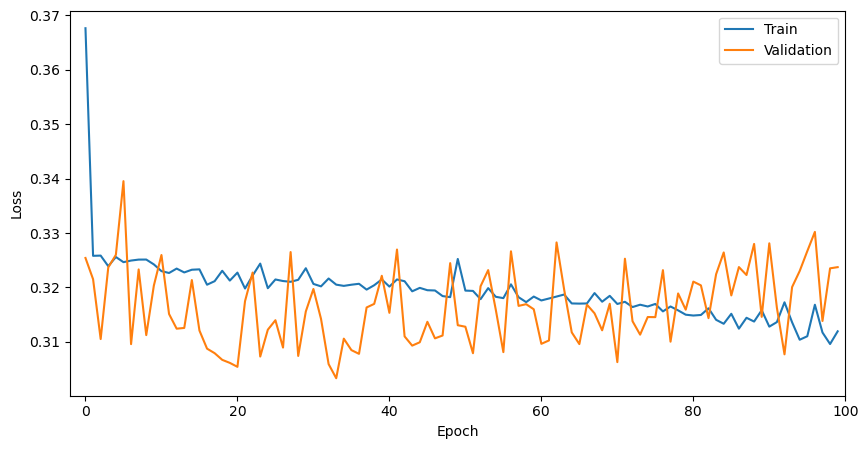

In [38]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(-2, num_epochs)
# plt.ylim(0.2,0.4)
plt.legend()
plt.show()

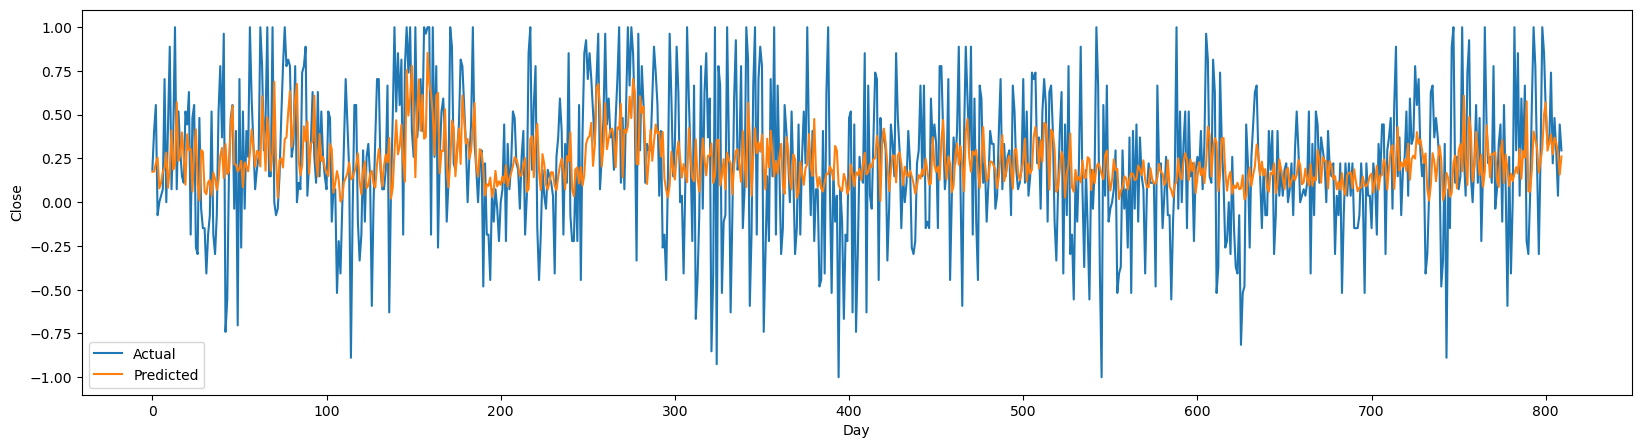

In [39]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

predicted = predicted[0:]

plt.figure(figsize=(20,5))
plt.plot(y_train, label='Actual')
plt.plot(predicted, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [40]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions[train_predictions >= 1] = 1
train_predictions

array([0.76805194, 0.76815992, 0.77156114, 0.77410778, 0.7609331 ,
       0.76329264, 0.7681468 , 0.76968658, 0.77624939, 0.76118733,
       0.76937862, 0.7857841 , 0.76904826, 0.77090332, 0.79789929,
       0.77278982, 0.77503678, 0.7849288 , 0.77427559, 0.76252588,
       0.7841012 , 0.77733608, 0.77780508, 0.75957861, 0.77602533,
       0.7862396 , 0.76268637, 0.75578965, 0.77739054, 0.77654108,
       0.75961555, 0.75842791, 0.76349712, 0.76456192, 0.75780865,
       0.76773269, 0.76498787, 0.76028102, 0.76483687, 0.77495411,
       0.7782803 , 0.7653055 , 0.77991509, 0.76700021, 0.76832183,
       0.78826462, 0.79640273, 0.77136068, 0.77099716, 0.76814688,
       0.76964959, 0.77273107, 0.76144917, 0.7720059 , 0.77035809,
       0.76823849, 0.77619013, 0.78616503, 0.77881805, 0.77027265,
       0.77696805, 0.77641097, 0.7703081 , 0.80047301, 0.78452685,
       0.76853412, 0.79139039, 0.782412  , 0.76845184, 0.77621108,
       0.80661404, 0.77316694, 0.75690555, 0.77289766, 0.77380

In [41]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([0.76888889, 0.78555556, 0.79666667, 0.74944444, 0.755     ,
       0.75777778, 0.76055556, 0.80777778, 0.755     , 0.78833333,
       0.82166667, 0.76055556, 0.78555556, 0.83      , 0.76055556,
       0.79388889, 0.77722222, 0.76611111, 0.76333333, 0.79388889,
       0.78833333, 0.80222222, 0.74111111, 0.79111111, 0.79666667,
       0.73555556, 0.73277778, 0.79111111, 0.75222222, 0.74388889,
       0.74388889, 0.72444444, 0.74111111, 0.74944444, 0.79388889,
       0.74111111, 0.73277778, 0.74944444, 0.79388889, 0.81333333,
       0.78277778, 0.82722222, 0.69944445, 0.71333333, 0.76888889,
       0.79111111, 0.79666667, 0.75222222, 0.78555556, 0.70222222,
       0.80777778, 0.73555556, 0.79388889, 0.75222222, 0.78555556,
       0.77444444, 0.83      , 0.79944444, 0.78      , 0.76055556,
       0.76888889, 0.77444444, 0.83      , 0.81333333, 0.77722222,
       0.79111111, 0.83      , 0.76611111, 0.76611111, 0.83      ,
       0.755     , 0.74944444, 0.75222222, 0.76611111, 0.79111

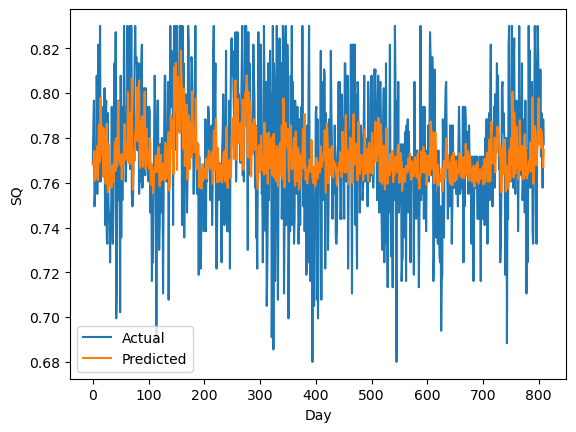

In [42]:
plt.plot(new_y_train, label='Actual')
plt.plot(train_predictions, label='Predicted')
plt.xlabel('Day')
plt.ylabel('SQ')
plt.legend()
plt.show()

In [43]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions[test_predictions >= 1] = 1
test_predictions = test_predictions[1:]

In [44]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test = new_y_test[:-1]

In [45]:
#accuracy = 1-np.sqrt(np.sum(((test_predictions-new_y_test)/new_y_test)**2)/len(new_y_test))
rmse = np.sqrt(np.mean((test_predictions-new_y_test)**2))

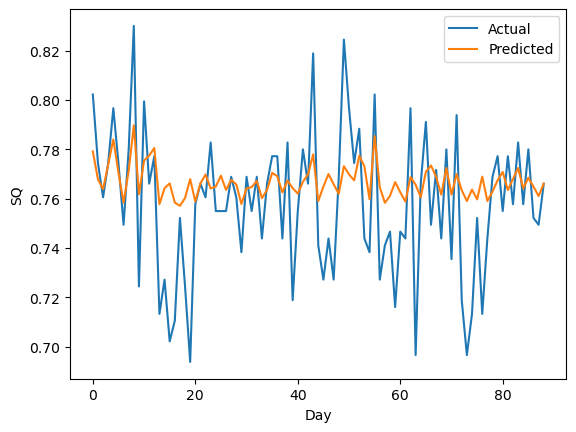


RMSE = 0.02654936449725039


In [46]:
plt.plot(new_y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Day')
plt.ylabel('SQ')
plt.legend()
plt.show()
print("\nRMSE =",rmse)

In [48]:
tensor = torch.Tensor(scaler.fit_transform(df['Sleep Quality'][-lookback:].values.reshape(-1,1))).reshape(-1,7,1).to(device)
pred = model(tensor).cpu().detach().numpy()
pred = scaler.inverse_transform(pred)
sq_lstm = pred.item()
pred.item()

0.7767115831375122

### MLP

In [50]:
dfml = pd.read_csv('C:/Users/91738/Desktop/CogNight/input/Sleep_Efficiency.csv')
dfml = dfml.drop(['Bedtime', 'Wakeup time', 'ID','REM sleep percentage','Deep sleep percentage','Light sleep percentage','Awakenings'] ,axis=1)
dfml['Smoking status'] = dfml['Smoking status'].map({'Yes':1 ,'No':0})
dfml['Gender'] = dfml['Gender'].map({'Male':1 ,'Female':0})
cols = [i for i in dfml.columns if i not in ["Sleep efficiency","Sleep duration"]]
dfml = dfml.dropna()
for col in cols:
  dfml[col] = dfml[col].astype(int)
dfml = dfml.reset_index().drop('index',axis=1)
dfml['Caffeine consumption'] = (dfml['Caffeine consumption']/25).astype(int)
dfml

,Age,Gender,Sleep duration,Sleep efficiency,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,65,0,6.0,0.88,0,0,1,3
1,69,1,7.0,0.66,0,3,1,3
2,40,0,8.0,0.89,0,0,0,3
3,40,0,6.0,0.51,2,5,1,1
4,57,1,8.0,0.76,0,3,0,3
...,...,...,...,...,...,...,...,...
402,30,0,7.5,0.53,2,2,1,1
403,27,0,7.5,0.91,0,0,0,5
404,52,1,6.0,0.74,1,0,0,3
405,45,1,7.0,0.76,0,0,0,3


In [51]:
#normalization

print(dfml['Age'].max(),dfml['Age'].min())

69 9


In [52]:
dfml['Age'] = (dfml['Age'].max()-dfml['Age'])/(dfml['Age'].max()-dfml['Age'].min())
dfml

,Age,Gender,Sleep duration,Sleep efficiency,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,0.066667,0,6.0,0.88,0,0,1,3
1,0.000000,1,7.0,0.66,0,3,1,3
2,0.483333,0,8.0,0.89,0,0,0,3
3,0.483333,0,6.0,0.51,2,5,1,1
4,0.200000,1,8.0,0.76,0,3,0,3
...,...,...,...,...,...,...,...,...
402,0.650000,0,7.5,0.53,2,2,1,1
403,0.700000,0,7.5,0.91,0,0,0,5
404,0.283333,1,6.0,0.74,1,0,0,3
405,0.400000,1,7.0,0.76,0,0,0,3


In [53]:
x_train_2 = dfml[ :int(len(dfml)*0.9)].drop('Sleep duration',axis=1)
x_test_2 = dfml[int(len(dfml)*0.9): ].reset_index().drop(['index','Sleep duration'],axis=1)
y_train_2 = dfml['Sleep duration'][ :int(len(dfml)*0.9)].reset_index().drop(['index'],axis=1)
y_test_2 = dfml['Sleep duration'][int(len(dfml)*0.9): ].reset_index().drop(['index'],axis=1)
x_train_2.shape, x_test_2.shape, y_train_2.shape, y_test_2.shape

((366, 7), (41, 7), (366, 1), (41, 1))

In [54]:
from sklearn import metrics

In [55]:
from sklearn.neural_network import MLPRegressor
import sklearn

In [56]:
mlpr = MLPRegressor(hidden_layer_sizes=(1,),solver='adam',learning_rate_init=0.1,random_state=25)
mlpr.fit(x_test_2,y_test_2)

MLPRegressor(hidden_layer_sizes=(1,), learning_rate_init=0.1, random_state=25)

In [57]:
y_pred_whole = mlpr.predict(x_test_2)
ame = sklearn.metrics.mean_absolute_error(y_test_2, y_pred_whole)
print(ame)

0.5284156729689568


###Taking Input

In [58]:
age = int(input("Age:"))
age = (69-age)/60
gender = int(input("Gender(1 for male, 0 for female):"))
sq = sq_lstm
caff = int(input("Caffeine(on a scale of 0 to 10):"))
alc = int(input("Alcohol(on a scale of 0 to 5):"))
smoke = int(input("Smoking status(0 for No, 1 for Yes):"))
exer = int(input("Exercise(on a scale of 0 to 5:)"))
user_input = np.array([age,gender,sq,caff,alc,smoke,exer])
user_input = np.reshape(user_input,(1,-1))

In [59]:
y_pred_2 = mlpr.predict(user_input)

print("You need to sleep for: %.2f Hours" % (y_pred_2.item()))

You need to sleep for: 6.85 Hours
